# Fitting

In [1]:
import os
import numpy as np
from numpy.testing import assert_array_equal, assert_array_almost_equal
import matplotlib.pyplot as plt
from casadi import (
    MX, DM, Function, Opti,
    vec, vcat, vertcat, horzcat, sum2, triu,
    gradient, jacobian, hessian
)

In [2]:
data_dir = 'data'

## Predator-Prey System Model

$$x_{k+1} = (a x_k - \alpha x_k y_k) / (1 + \gamma x_k)$$ 
$$y_{k+1} = (b y_k - \beta x_k y_k) / (1 + \delta y_k)$$ 

Unknown parameters:

$$
p = \left[
\begin{matrix}
    a & b & \alpha & \beta & \gamma & \delta
\end{matrix} 
\right]^T$$


## 1. Alternative Formulations

### 1.1. Simulate the estimated population dynamics without CasADi

In [3]:
def state_transition(z, a, b, alpha, beta, gamma, delta):
    xk, yk = z[0], z[1]
    xkp1 = (a * xk - alpha * xk * yk) / (1 + gamma * xk)
    ykp1 = (b * yk + beta * xk * yk) / (1 + delta * yk)
    return xkp1, ykp1

p = [1.43, 0.99, 0.22, 0.022, 0.022, 0.011]
xk, yk = [10, 0.1]
print(f"{0:3d}: ({xk:.4f}, {yk:.4f})")
N = 10
z_predicted = [(xk, yk)]
for k in range(1, N+1):
    xk, yk = state_transition((xk, yk), *p)
    z_predicted.append((xk, yk))
    print(f"{k:3d}: ({xk:.4f}, {yk:.4f})")
z_predicted = np.array(z_predicted)

  0: (10.0000, 0.1000)
  1: (11.5410, 0.1209)
  2: (12.9171, 0.1501)
  3: (14.0516, 0.1910)
  4: (14.8979, 0.2476)
  5: (15.4339, 0.3254)
  6: (15.6513, 0.4311)
  7: (15.5445, 0.5725)
  8: (15.1051, 0.7578)
  9: (14.3225, 0.9938)
 10: (13.1929, 1.2829)


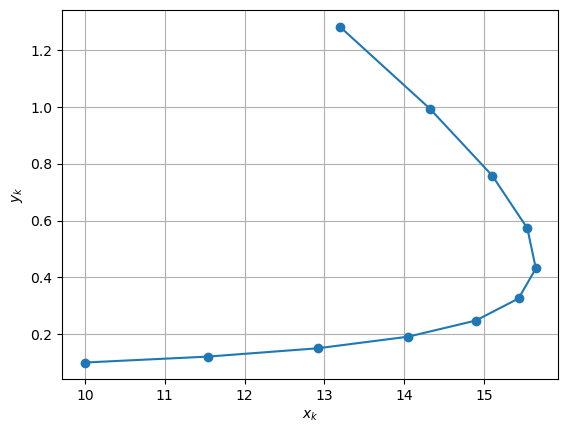

In [4]:
plt.plot(z_predicted[:, 0], z_predicted[:, 1], marker='o')
plt.xlabel('$x_k$')
plt.ylabel('$y_k$')
plt.grid()

In [5]:
assert_array_almost_equal(np.array([xk, yk]), [13.1929, 1.2829], decimal=4)

### 1.2. Compute sum-of-squared-deviations

In [6]:
filename = 'data.mat'
z_data = np.loadtxt(os.path.join(data_dir, filename))
z_data.shape

(101, 2)

In [7]:
errors = z_data[:11] - z_predicted
errors

array([[ 0.        ,  0.        ],
       [-0.87431694, -0.01097694],
       [-1.6817023 , -0.02793707],
       [-2.34973866, -0.05371554],
       [-2.83088477, -0.09214206],
       [-3.09893528, -0.14823668],
       [-3.13951539, -0.22829839],
       [-2.94064131, -0.33971614],
       [-2.48754172, -0.49022574],
       [-1.76403134, -0.68624828],
       [-0.7615959 , -0.93001532]])

In [8]:
sse = np.sum((errors) ** 2)
sse

56.8927241998227

In [9]:
assert round(sse, 3) == 56.893

### 1.3. Fit parameters

In [10]:
opti = Opti()

N = 100
a = opti.variable()
b = opti.variable()
alpha = opti.variable() 
beta = opti.variable()
gamma = opti.variable()
delta = opti.variable()
p = vertcat(a, b, alpha, beta, gamma, delta)

# Construct objective function and add constraints
xk, yk = 10, 0.1
f = 0
k = 0
while True:
    f += sum2((xk - z_data[k, 0]) ** 2 + (yk - z_data[k, 1]) ** 2)
    if k == N:
        break
    xk, yk = state_transition(vertcat(xk, yk), a, b, alpha, beta, gamma, delta)
    k += 1

f.shape

(1, 1)

In [11]:
opti.minimize(f)
opti.solver('ipopt')
opti.set_initial(p, [1.43, 0.99, 0.22, 0.022, 0.022, 0.011])

sol = opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       21

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality c

In [12]:
sol.value(p)

array([1.3 , 0.9 , 0.2 , 0.02, 0.02, 0.01])

In [13]:
assert_array_almost_equal(sol.value(p), [1.3 , 0.9 , 0.2 , 0.02, 0.02, 0.01])

## 2. CasADi solvers

### 1.2 Reformulate implementation

In [14]:
opti = Opti()

N = 100
a = opti.variable()
b = opti.variable()
alpha = opti.variable() 
beta = opti.variable()
gamma = opti.variable()
delta = opti.variable()
p = vertcat(a, b, alpha, beta, gamma, delta)

# Construct objective function and add constraints
xk, yk = 10, 0.1
F = []
k = 0
while True:
    F.append(xk - z_data[k, 0])
    F.append(yk - z_data[k, 1])
    if k == N:
        break
    xk, yk = state_transition(vertcat(xk, yk), a, b, alpha, beta, gamma, delta)
    k += 1

F = vertcat(*F)
F.shape

(202, 1)

In [15]:
opti.minimize(F.T @ F)
opti.solver('ipopt')
opti.set_initial(p, [1.43, 0.99, 0.22, 0.022, 0.022, 0.011])
sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       21

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.1360947e+03 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [16]:
sol.value(p)

array([1.3 , 0.9 , 0.2 , 0.02, 0.02, 0.01])

In [17]:
assert_array_almost_equal(sol.value(p), [1.3 , 0.9 , 0.2 , 0.02, 0.02, 0.01])

### 2.2. Pass a custom Hessian H to IPOPT

In [18]:
opti = Opti()

N = 100
a = opti.variable()
b = opti.variable()
alpha = opti.variable() 
beta = opti.variable()
gamma = opti.variable()
delta = opti.variable()
p = vertcat(a, b, alpha, beta, gamma, delta)

# Construct objective function and add constraints
xk, yk = 10, 0.1
F = []
k = 0
while True:
    F.append(xk - z_data[k, 0])
    F.append(yk - z_data[k, 1])
    if k == N:
        break
    xk, yk = state_transition(vertcat(xk, yk), a, b, alpha, beta, gamma, delta)
    k += 1

F = vertcat(*F)  # can also use vcat(F)
F.shape

(202, 1)

Least-squares minimization update

$$\Delta x = - (\nabla^2 f)^{-1} \nabla f $$

Gauss-Newton Hessian approximation

$$\nabla^2f = J^T J$$

In [19]:
opti.minimize(F.T @ F)

In [20]:
J = jacobian(F, p)
J.shape

(202, 6)

In [21]:
H = 2 * J.T @ J  # need to include the 2 here because obj. func. excluded the 1/2

In [22]:
sigma = MX.sym('sigma')
hess_lag = Function(
    'hess_lag',
    [opti.x, opti.p, sigma, opti.lam_g],
    [sigma * triu(H)]
)
opts = {'hess_lag': hess_lag}
opti.solver('ipopt', opts)

In [23]:
opti.set_initial(p, [1.43, 0.99, 0.22, 0.022, 0.022, 0.011])
sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       21

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.1360947e+03 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [24]:
assert_array_almost_equal(sol.value(p), [1.3 , 0.9 , 0.2 , 0.02, 0.02, 0.01])

### 2.3. Reformulate again

In [25]:
opti = Opti()

N = 100
a = opti.variable()
b = opti.variable()
alpha = opti.variable() 
beta = opti.variable()
gamma = opti.variable()
delta = opti.variable()
p = vertcat(a, b, alpha, beta, gamma, delta)

xk, yk = 10, 0.1

# Simulate system
# Z = []
# for k in range(1, N + 1):
#     xk, yk = state_transition(vertcat(xk, yk), a, b, alpha, beta, gamma, delta)
#     Z.append(horzcat(xk, yk))
# Z = vcat(Z)

# Using a list comprehension
z = horzcat(10, 0.1)
Z = vcat([z] + [
    (z := horzcat(*state_transition(z, a, b, alpha, beta, gamma, delta)))
    for k in range(1, N + 1)
])

Z.shape

(101, 2)

In [26]:
S = Function('S', [p], [Z], ['p'], ['Z'])
S

Function(S:(p[6])->(Z[101x2]) MXFunction)

In [27]:
F = vec(S(p) - z_data)
opti.minimize(F.T @ F)
opti.solver('ipopt', opts)

In [28]:
opti.set_initial(p, [1.43, 0.99, 0.22, 0.022, 0.022, 0.011])
sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       21

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.1360947e+03 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [29]:
assert_array_almost_equal(sol.value(p), [1.3 , 0.9 , 0.2 , 0.02, 0.02, 0.01])

### 2.4. Outlier in the data

In [30]:
z_data_outlier = z_data.copy()
z_data_outlier[9, 0] = 1

opti = Opti()

N = 100
a = opti.variable()
b = opti.variable()
alpha = opti.variable() 
beta = opti.variable()
gamma = opti.variable()
delta = opti.variable()
p = vertcat(a, b, alpha, beta, gamma, delta)

x, y = 10, 0.1
z = horzcat(10, 0.1)
Z = vcat([z] + [
    (z := horzcat(*state_transition(z, a, b, alpha, beta, gamma, delta)))
    for k in range(1, N + 1)
])
S = Function('S', [p], [Z], ['p'], ['Z'])

F = vec(S(p) - z_data_outlier)
opti.minimize(F.T @ F)

opti.solver('ipopt')
p0 = [1.43, 0.99, 0.22, 0.022, 0.022, 0.011]
opti.set_initial(p, p0)
sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       21

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.3104722e+03 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [31]:
p_sol = sol.value(p)
p_sol

array([ 1.31922177,  0.84966348,  0.19291711,  0.02440464,  0.02408137,
       -0.01738025])

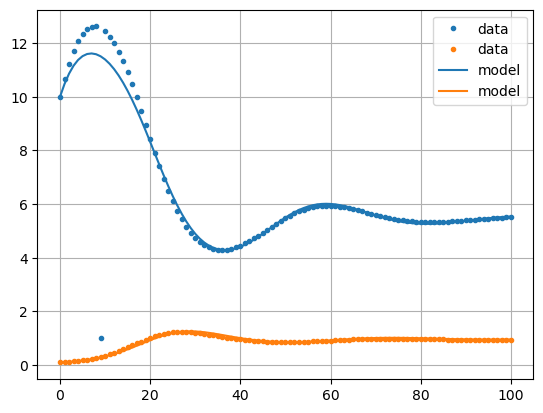

In [32]:
z_pred = S(p_sol)
colors = ['tab:blue', 'tab:orange']
lines = plt.plot(z_data_outlier, ls='none', marker='.', label='data')
for i, line in enumerate(lines):
    plt.plot(z_pred[:, i], label='model', color=line.get_color())
plt.legend()
plt.grid()
plt.show()